# Stochastic gradient descent

In [45]:
import numpy as np
import pandas as pd
import random
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.othermod.betareg import BetaModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy.special import digamma
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

## Классы стоперов, градиентов и регрессоров

In [27]:
class Stoper:
    """
    Базовый класс для любого стопера.
    """
    def __init__(self):
        pass

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
                x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен, 
            False - иначе.
        """
        return True


class StoperK(Stoper):
    """
    Класс стопера, критерием которого является количество итераций.
    """
    def __init__(self, max_step: int = 100):
        """
        Инициализирует класс итерирующего стопера.

        Параметры:
        ----------
            max_step (int): максимальное количество итераций.
        """
        super().__init__()
        self.max_step = max_step
        self.k = 0

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
            x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен,
            False - иначе.
        """
        if self.k >= self.max_step:
            return True

        self.k += 1

        return False


class StoperPoint(Stoper):
    """
    Класс стопера, критерием которого является
    норма разности нынешней и прошлой точки.
    """
    def __init__(self, epsilon: float = 1e-3, max_step: int = 1000000):
        """
        Инициализирует класс итерирующего стопера.

        Параметры:
        ----------
            epsilon (float): условие на норму разности.

            max_step (int): максимальное количество итераций.
        """
        super().__init__()
        self.max_step = max_step
        self.epsilon = epsilon
        self.k = 0

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
            x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен,
            False - иначе.
        """
        if self.k >= self.max_step:
            return True

        self.k += 1

        if self.k == 1:
            self.back_x = x
        else:
            norm = np.linalg.norm(x - self.back_x)
            self.back_x = x

            return not norm >= self.epsilon

        return False


class Direction:
    """
    Базовый класс для направления по которому идёт градиентный спуск.
    """
    def __init__(self, size_param: int):
        """
        Инициализирует класс направления.

        Параметры:
        ----------
            size_param (int): размерность оптимизируемого значения.
        """
        self.size_param = size_param

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        return np.zeros(self.size)


def simple_derivative(x: np.array, X: np.array, y: np.array, size: int):
    """
    Производная для метода наименьших квадратов.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти производную.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.

        size (int): размер выборки.
    """
    return 2 / size * X.T.dot(X.dot(x) - y)


def log_likelyhood_simple(x: np.array, X: np.array, y: np.array):
    """
    Функция правдоподобия для обычной линейной регрессии.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти функцию правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    errors = y - X.dot(x)
    sigma = np.var(errors)
    
    return -np.sum(0.5 * np.log(2 * np.pi) + np.log(sigma) + errors ** 2 / (2 * sigma ** 2))


class DirectionData(Direction):
    """
    Класс направления для задачи линейной регрессии.
    """
    def __init__(self, X: np.array, y: np.array, derivative, alpha: float = 1e-3):
        """
        Инициализирует класс направления для задачи линейной регрессии.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска. 
        """
        self.X = X
        self.y = y
        self.derivative = derivative
        self.alpha = alpha
        self.size = y.shape[0]
        self.size_param = X.shape[1]

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        return -self.alpha * self.derivative(x, self.X, self.y, self.size)


class DirectionDataStochastic(DirectionData):
    """
    Класс направления для задачи линейной регрессии со стохастическим методом.
    """
    def __init__(
        self,
        X: np.array,
        y: np.array,
        derivative,
        alpha: float = 1e-3,
        batch_size: int = 64,
    ):
        """
        Инициализирует класс направления для задачи линейной регрессии
        со стохастическим методом.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска. 

            batch_size (int): размер батча для взятия подвыборки.
        """
        super().__init__(X, y, derivative, alpha)
        self.batch_size = batch_size

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        batch = random.sample(
            range(self.X.shape[0]), min(self.batch_size, self.y.shape[0])
        )
        X_batch, y_batch = self.X[batch], self.y[batch]

        return -self.alpha * self.derivative(x, X_batch, y_batch, self.batch_size)


class DirectionDataRMSprop(DirectionDataStochastic):
    """
    Класс направления для задачи линейной регрессии с методом RMSprop .
    """
    def __init__(
        self,
        X: np.array,
        y: np.array,
        derivative,
        alpha: float = 1e-3,
        batch_size: int = 64,
        eta: float = 0.1,
    ):
        """
        Инициализирует класс направления для задачи линейной регрессии
        с методом RMSprop.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска. 

            batch_size (int): размер батча для взятия подвыборки.

            eta (float): параметр сглаживания.
        """
        super().__init__(X, y, derivative, alpha, batch_size)
        self.eta = eta
        self.back_direct = []
        self.G = []

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        batch = random.sample(
            range(self.X.shape[0]), min(self.batch_size, self.y.shape[0])
        )
        X_batch, y_batch = self.X[batch], self.y[batch]

        self.back_direct.append(
            self.alpha * self.derivative(x, X_batch, y_batch, self.batch_size)
        )
        k = self.back_direct[-1].shape[0]
        matrixF = np.zeros((k, k))

        for deltaF_k in self.back_direct:
            matrixF += deltaF_k.dot(deltaF_k.T)

        if len(self.back_direct) == 1:
            self.G.append(matrixF)
        else:
            self.G[0] = self.eta * self.G[0] + (1 - self.eta) * matrixF

        return -self.back_direct[-1] * (np.diag(self.G[0]) + np.ones(k) * 1e-8) ** (
            -1 / 2
        )


def logit_fun(x: np.array):
    """
    Logit функция для перевода величины, которая принимает вещественные значения,
    в величину, которая принимает значения от 0 до 1.
    """
    return 1 / (1 + np.exp(-x))


def log_likelyhood_beta(x: np.array, X: np.array, y: np.array):
    """
    Функция правдоподобия для бета-регрессии.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти функцию правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    phi = x[0]
    beta = x[1:]
    mu = logit_fun(X.dot(beta))

    log_gamma_phi = np.log(gamma(phi))
    log_gamma_mu_phi = np.log(gamma(mu * phi))
    log_gamma_minus_mu_phi = np.log(gamma((1 - mu) * phi))
    
    return np.sum(log_gamma_phi - log_gamma_mu_phi - log_gamma_minus_mu_phi + (mu * phi - 1) * np.log(y) + ((1 - mu) * phi - 1) * np.log(1 - y))


def logbeta_derivative(x: np.array, X: np.array, y: np.array, size: int):
    """
    Производная для бета-регрессии (производная функции правдоподобия).

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти производную.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.

        size (int): размер выборки.
    """
    phi = x[0]
    beta = x[1:]
    mu = logit_fun(X.dot(beta))

    grad_mu = np.tile(np.array([mu * (1 - mu)]).transpose(), (1, X.shape[1])) * X

    digamma_mu_phi = digamma(mu * phi)
    digamma_1_minus_mu_phi = digamma((1 - mu) * phi)

    dl_dbeta = np.sum(
        np.tile(
            np.array(
                [
                    phi
                    * (
                        digamma_1_minus_mu_phi
                        - digamma_mu_phi
                        + np.log(y)
                        - np.log(1 - y)
                    )
                ]
            ).transpose(),
            (1, X.shape[1]),
        )
        * grad_mu,
        axis=0,
    )

    dl_dphi = np.sum(
        digamma(phi)
        - mu * digamma_mu_phi
        - (1 - mu) * digamma_1_minus_mu_phi
        + mu * np.log(y)
        + (1 - mu) * np.log(1 - y)
    )

    return -np.hstack((dl_dphi, dl_dbeta))


def BIC(log_likelyhood, x: np.array, X: np.array, y: np.array):
    """
    Байесовский информационный критерий.

    Параметры:
    ----------
        log_likelyhood (function): функция максимального правдоподобия.

        x (np.array): точка, в которой считается функция максимального правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    X = scale(X)
    X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))

    return x.shape[0] * np.log(X.shape[0]) - 2 * log_likelyhood(x, X, y)


class GradDesc:
    """
    Класс градиентного спуска.
    """
    def __init__(self, stoper: Stoper):
        """
        Инициализирует класс градиентного спуска.

        Параметры:
        ----------

            stoper (Stoper): класс для критерия остановки градиентного спуска.
        """
        self.stoper = stoper

    def optimise(
        self, direction: Direction = Direction(1), start_point: np.array = None
    ):
        """
        Ищет точку минимума функции градиентным спуском.

        Параметры:
        ----------

            direction (Direction): класс направления градиентного спуска.

            start_point (np.array): начальная точка поика минимума (опционально).

        Возвращаемое значение:
        ----------------------

            x_t (np.array): точка минимума функции.
        """
        if start_point is None:
            start_point = np.zeros(direction.size_param)

        x_t = start_point

        while not self.stoper.stop(x_t):
            x_t = x_t + direction.get_direction(x_t)

        return x_t


class SGDLinearRegressor(RegressorMixin):
    """
    Класс линейной регрессии.
    """
    def __init__(self, stoper: Stoper, alpha: float = 0.01, batch_size: int = 64):
        """
        Инициализирует класс линейной регрессии.

        Параметры:
            stoper (Stoper): класс критерия остановки градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.
        """
        self.grad_desc = GradDesc(stoper)
        self.alpha = alpha
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.W = None

    def fit(self, X: np.array, y: np.array):
        """
        Тренирует модель линейной регрессии на данных и таргете.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

        Возвращаемое значение:
        ----------------------
            self (SGDLinearRegressor): сам класс линейной регрессии.
        """
        X = self.scaler.fit(X).transform(X)
        X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))

        
        self.W = self.grad_desc.optimise(
            DirectionDataRMSprop(
                X, np.array(y), simple_derivative, self.alpha, self.batch_size
            )
        )

        return self

    def predict(self, X: np.array):
        """
        Предсказывает значение таргета на данных.

        Параметры:
        ----------
            X (np.array): матрица данных.

        Возвращаемое значение:
        ----------------------
            y (np.array): предсказанный таргет.
        """
        X = self.scaler.transform(X)
        return np.hstack((X, np.ones((X.shape[0], 1)))).dot(self.W)


class SGDBetaRegressor(RegressorMixin):
    """
    Класс бета-регрессии.
    """
    def __init__(self, stoper: Stoper, alpha: float = 0.01, batch_size: int = 64):
        """
        Инициализирует класс бета-регрессии.

        Параметры:
            stoper (Stoper): класс критерия остановки градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.
        """
        self.grad_desc = GradDesc(stoper)
        self.alpha = alpha
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.W = None

    def fit(self, X, y):
        """
        Тренирует модель бета-регрессии на данных и таргете.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

        Возвращаемое значение:
        ----------------------
            self (SGDLinearRegressor): сам класс бета-регрессии.
        """
        X = self.scaler.fit(X).transform(X)
        X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))
        self.W = self.grad_desc.optimise(
            DirectionDataRMSprop(
                np.array(X),
                np.array(y),
                logbeta_derivative,
                self.alpha,
                self.batch_size,
            ),
            start_point=np.hstack((1, np.zeros(X.shape[1]))),
        )
        
        self.phi = self.W[0]
        self.W = self.W[1:]

        return self

    def predict(self, X):
        """
        Предсказывает значение таргета на данных.

        Параметры:
        ----------
            X (np.array): матрица данных.

        Возвращаемое значение:
        ----------------------
            y (np.array): предсказанный таргет.
        """
        X = self.scaler.transform(X)
        return logit_fun(np.hstack((np.array(X), np.ones((X.shape[0], 1)))).dot(self.W))
    
    

## Анализ и результаты

Для начала проверим обычный градиентный спуск на простой функции. Пусть это будет:
$$
y = x ^2 + 3 x + 2
$$
Точка минимума у такой функции является $x = -1.5$:

In [28]:
class DirectionPolynome:
    def __init__(self, size_param = 1):
        self.size_param = size_param

    def get_direction(self, x: np.array):
        return -1e-2 * (2 * x + 3)


GradDesc(StoperK(1000)).optimise(DirectionPolynome(), start_point=np.array([0]))

array([-1.5])

Всё верно.

### Линейная регрессия

Теперь проверим модификацию градиентного спуска (RMSprop) в задаче линейной регрессии. Для чего сгенирируем матрицу нормальных величин $\mathbf{X} \in \mathbb{R} ^{n \times m}$ и таргет $\overline{y} \in \mathbb{R} ^{n}$, зависимый от матрицы $\mathbf{X}$, где $n = 1000$, $m = 6$ (истинные коэффициенты можете видеть ниже):

In [29]:
n = 1000
w_true = np.array([1, 2, -1, 6, 0.3, -2])

np.random.seed(42)

X = np.random.normal(0, 1, (n, 5))
y = np.hstack((X, np.ones((n, 1)))).dot(w_true) + np.random.normal(0, 1, (n))
print(X)
print(y)

[[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
 [-0.23413696  1.57921282  0.76743473 -0.46947439  0.54256004]
 [-0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783]
 ...
 [ 1.63579781 -0.22104246  0.0693698   0.19259692  2.39210964]
 [-2.09935626  0.68322301 -0.11480225  0.56677173 -0.65737255]
 [-0.04896503  0.71141058  3.1129102   0.80803619 -0.8480656 ]]
[ 6.21667046e+00 -2.95063847e+00 -1.74296395e+01 -1.11041229e+01
 -9.03240689e+00 -9.53233497e+00 -3.93467247e+00 -8.26572944e+00
 -3.78756067e+00 -3.30697592e+00  3.80852081e+00  5.75849389e-01
 -8.66885556e+00 -5.27162055e-02  1.01518423e+01 -1.26246558e+00
 -8.44025969e+00 -1.98210700e+00 -1.19185970e+00 -2.77387780e+00
 -8.83390395e+00  2.78969662e+00  1.05037907e+01  4.88392388e+00
 -1.03885000e+01 -2.01196580e+00 -8.17472738e-01  2.37707414e+00
  4.92307239e+00  8.63631858e-01 -1.31277880e-01 -5.15315186e+00
 -6.46318849e+00 -2.99990632e+00 -1.59837996e+00 -9.77875393e-01
  2.99513528e+00 -6.48862716e+0

Разобьём эту выборку на трейн и тест:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

И применим наш класс линейной регрессии, проверив на тесте метрики RMSE, $R ^2 _{\text{adj}}$ и BIC:

In [31]:
reg = SGDLinearRegressor(StoperPoint(max_step=1000), alpha=1e-3, batch_size=64)
reg = reg.fit(X_train, y_train)
print(reg.W)
y_pred = reg.predict(X_test)
print(root_mean_squared_error(y_test, y_pred))
print(
    1
    - (1 - r2_score(y_test, y_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, reg.W, X_test, y_test))

[ 0.98916325  2.05355263 -1.02132655  5.81031782  0.35006198 -2.19851591]
1.0011673564263042
0.9741400754147338
859.1555817310243


Насколько метрики RMSE и BIC хороши трудно сказать, пока мы не сравнили с другим алгоритмом, однако поправленный $R ^2$ говорит о том, что модель хорошо соответсвует данным.

Теперь применим к тем же данным линейную регрессию из пакета `sklearn`:

In [32]:
reg_lr = LinearRegression()
reg_lr = reg_lr.fit(X_train, y_train)
print(np.hstack((reg_lr.coef_, reg_lr.intercept_)))
y_pred = reg_lr.predict(X_test)
print(root_mean_squared_error(y_test, y_pred))
print(
    1
    - (1 - r2_score(y_test, y_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, np.hstack((reg_lr.coef_, reg_lr.intercept_)), X_test, y_test))

[ 1.00677975  2.01830113 -1.0104927   6.02137558  0.34293177 -2.05958543]
1.0045385531853415
0.9739656277149537
855.3975103368077


Результаты почти неотличимы от нашего подхода, на всё же лучше.

### Бета-регрессия

Теперь приступим к бета-регрессии, которая применяется для данных, когда таргет имеет значения от $0$ до $1$ не включительно.

Сгенерируем данные для бета-регрессии для чего просто с помощью `logit` функции переведём таргет в нужный диапозон:

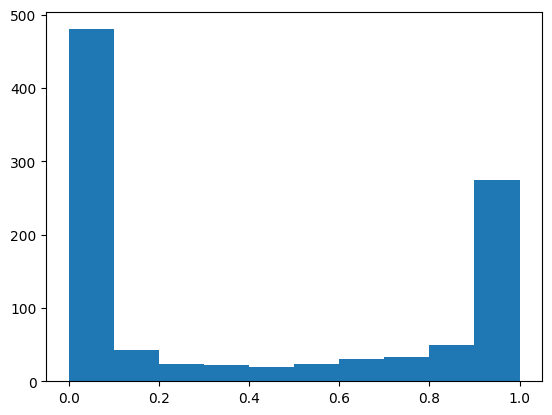

In [51]:
y_beta = logit_fun(np.hstack((scale(X), np.ones((n, 1)))).dot(w_true) + np.random.normal(0, 1, (n)))
plt.hist(y_beta, bins=10)
plt.show()

И применим к этим данным сначала линейную, потом бета-регрессию:

In [52]:
X_beta_train, X_beta_test, y_beta_train, y_beta_test = train_test_split(
    X, y_beta, test_size=0.25, random_state=42
)

reg_model_b = SGDLinearRegressor(StoperPoint(max_step=1000), alpha=1e-3, batch_size=64)
reg_model_b = reg_model_b.fit(X_beta_train, y_beta_train)
print(reg_model_b.W)
y_pred_b = reg_model_b.predict(X_beta_test)
print(root_mean_squared_error(y_beta_test, y_pred_b))
print(
    1
    - (1 - r2_score(y_beta_test, y_pred_b))
    * (len(y_beta_test) - 1)
    / (len(y_beta_test) - X_beta_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, reg_model_b.W, X_beta_test, y_beta_test))

[ 0.05000572  0.09768447 -0.06767869  0.33003329 -0.00940782  0.3922967 ]
0.23672201630000234
0.6992946245330802
3698.0431622190604


In [54]:
beta_reg_model = SGDBetaRegressor(StoperPoint(1e-3, max_step=1000), alpha=1e-3, batch_size=64)
beta_reg_model = beta_reg_model.fit(X_beta_train, y_beta_train)
print(w_true)
print(beta_reg_model.W)
y_beta_pred_model = beta_reg_model.predict(X_beta_test)
print(root_mean_squared_error(y_beta_test, y_beta_pred_model, sample_weight=(1 + beta_reg_model.phi) / (y_beta_pred_model * (1 - y_beta_pred_model))))
print(BIC(log_likelyhood_beta, np.hstack((beta_reg_model.phi, beta_reg_model.W)), X_beta_test, y_beta_test))

[ 1.   2.  -1.   6.   0.3 -2. ]
[ 0.40111935  0.87386957 -0.39197314  2.56884536  0.1154546  -0.85096191]
0.04146668863245592
-1428.684823179674


Я взял данные по качеству сна студентов. В таблице представлены следующие признаки:

- Age - возраст;
- Gender - пол;
- University_Year - год обучения;
- Sleep_Duration - продолжительность сна;
- Study_Hours - количество часов на учёбу за день;
- Screen_Time - количество часов экранного времени за день;
- Caffeine_Intake - среднее количество напитков с кофеином за день;
- Physical_Activity - среднее количество минут на физическую активность за день;
- Sleep_Quality	- субъективная оценка сна от $1$ до $10$;
- Weekday_Sleep_Start - время, когда студент ложится спать в будние дни;
- Weekend_Sleep_Start - время, когда студент ложится спать в выходные дни;
- Weekday_Sleep_End - время, когда студент встаёт в будние дни;
- Weekend_Sleep_End - время, когда студент встаёт в выходные дни.

Будем предсказывать качество сна, для чего преобразуем таргет в вектор от нуля до единицы не включительно. А так же пол преобразуем OneHot кодированием:

In [47]:
beta_data = pd.read_csv("student_sleep_patterns.csv", sep=",")
beta_data = beta_data.drop(columns="Student_ID")
beta_data = pd.get_dummies(beta_data, columns=["Gender"], drop_first=True, dtype="int8")
beta_data["University_Year"] = [int(year[0]) for year in beta_data["University_Year"]]
target_column = "Sleep_Quality"
features_columns = beta_data.drop(columns=target_column).columns

beta_data["Sleep_Quality"] = (
    beta_data["Sleep_Quality"] / max(beta_data["Sleep_Quality"]) - 0.05
)

beta_data.head()

,Age,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,Gender_Male,Gender_Other
0,24,2,7.7,7.9,3.4,2,37,0.95,14.16,4.05,7.41,7.06,0,1
1,21,1,6.3,6.0,1.9,5,74,0.15,8.73,7.10,8.21,10.21,1,0
2,22,4,5.1,6.7,3.9,5,53,0.45,20.00,20.47,6.88,10.92,1,0
3,24,4,6.3,8.6,2.8,4,55,0.85,19.82,4.08,6.69,9.42,0,1
4,20,4,4.7,2.7,2.7,0,85,0.25,20.98,6.12,8.98,9.01,1,0


Посмотрим на расперделения таргета:

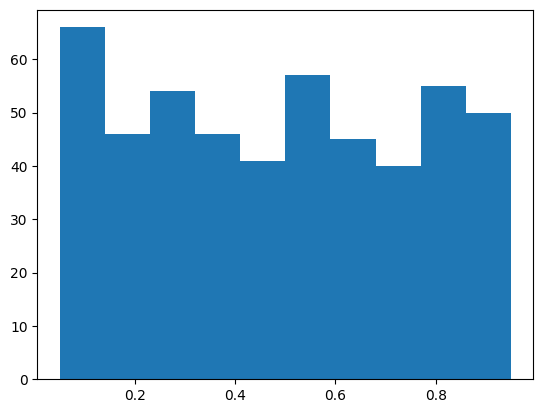

In [37]:
plt.hist(beta_data[target_column], bins=10)
plt.show()

Близко к равномерному, хотя вполне возможно, что слева есть небольшое увеличение количества.

Разделим на трейн и тест:

In [38]:
beta_data_train, beta_data_test, target_train, target_test = train_test_split(
    beta_data[features_columns], beta_data[target_column], test_size=0.25, random_state=42
)

Начнём с линейной регрессии. Посмотрим, может, будет неплохо:

In [40]:
reg_b = SGDLinearRegressor(StoperPoint(max_step=1000), alpha=1e-3, batch_size=64)
reg_b = reg_b.fit(beta_data_train, target_train)
print(reg_b.W)
y_pred_b = reg_b.predict(beta_data_test)
print(root_mean_squared_error(target_test, y_pred_b))
print(
    1
    - (1 - r2_score(target_test, y_pred_b))
    * (len(target_test) - 1)
    / (len(target_test) - beta_data_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, reg_b.W, beta_data_test, target_test))

[-6.22124512e-03 -1.20346004e-02  3.29574124e-04  1.79197048e-02
  1.38279139e-02  6.95112305e-03 -1.85436606e-02 -6.44458647e-03
  6.57673869e-03 -1.79171352e-02 -1.37556882e-02 -3.42013796e-02
  9.52632497e-03  5.13662269e-01]
0.31296537824645954
-0.20932151446919
1086.97736913916


Судя по отрицательному значению поправленного $R ^2$ линейная модель здесь не очень хороша.

Применим нашу бета-регрессию к данным и посмотрим на весовой RMSE и BIC:

In [41]:
beta_reg = SGDBetaRegressor(StoperPoint(1e-5, max_step=1000), alpha=1e-3, batch_size=64)
beta_reg = beta_reg.fit(beta_data_train, target_train)
print(beta_reg.W)
print(beta_reg.phi)
y_pred = beta_reg.predict(beta_data_test)
print(root_mean_squared_error(target_test, y_pred, sample_weight=(1 + beta_reg.phi) / (y_pred * (1 - y_pred))))
print(BIC(log_likelyhood_beta, np.hstack((beta_reg.phi, beta_reg.W)), beta_data_test, target_test))

[ 0.02195382  0.02745827  0.0374904   0.06578509 -0.02612991  0.04508176
  0.05030977 -0.005901    0.0223599   0.00542515 -0.03026275 -0.00728989
  0.06010478 -0.01304699]
2.135825121906761
0.30840566683208
77.04684753646032


Судя по RMSE результат не очень, так как можно сказать, что мы ошибаемся в среднем на $30 \%$, что много. А по BIC мы сможем сравнить с пакетом `statsmodels`:

In [13]:
beta_reg_mod = BetaModel(target_train, np.hstack((np.array(beta_data_train), np.ones((beta_data_train.shape[0], 1)))))
beta_reg_mod = beta_reg_mod.fit()
print(beta_reg_mod.summary())

y_pred_mod = beta_reg_mod.predict(np.hstack((np.array(beta_data_test), np.ones((beta_data_test.shape[0], 1)))))
print(root_mean_squared_error(target_test, y_pred_mod, sample_weight=(1 + beta_reg_mod.params["precision"]) / (y_pred_mod * (1 - y_pred_mod))))
print(BIC(log_likelyhood_beta, np.hstack((np.exp(beta_reg_mod.params["precision"]), beta_reg_mod.params[:-1])), beta_data_test, target_test))

                              BetaModel Results                               
Dep. Variable:          Sleep_Quality   Log-Likelihood:                 2.7516
Model:                      BetaModel   AIC:                             24.50
Method:            Maximum Likelihood   BIC:                             83.40
Date:                Sat, 14 Dec 2024                                         
Time:                        11:16:35                                         
No. Observations:                 375                                         
Df Residuals:                     360                                         
Df Model:                          13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0005      0.024     -0.021      0.983      -0.047       0.046
x2             0.0241      0.052      0.460      0.6

С точки зрения RMSE алгоритмы примерно равны, но вот по BIC наша модель показала себя даже лучше.